### Isolation Forest

Данный подход не требует нормальности данных (в смысле рабочего состояния системы), т.е. в данных могут быть аномалии. **Из-за своей склонности к изоляции аномалии изолируются ближе к корню дерева.** В то время как нормальные состояния системы находится как можно глубже. При моделировании строится ансамбль деревьев для предлагаемого датасета, тогда аномалии - это те экземпляры, которые имеют короткую среднюю длину пути. Существует два гиперпараметра модели: количество деревьев в лесу и размер подвыборки.

Изолировать - это значит отделить один объект от остальных. Аномалии наиболее предрасположены к изоляции, поскольку их мало и они отличаются от нормальных объектов. В случайном дереве разбиение экземпляров рекурсивно повторяется до тех пор, пока все экземпляры не будут изолированы. Если лес случайных деревьев вместе создает более короткие пути для некоторых конкретных точек, то они, скорее всего, будут аномалиями. 

Нормальный объект требует больших разбиений для того чтобы быть изолированным, в то время как аномальный объект будет отделен на более ранней стадии. **При разбиении рандомно выбирается признак и сплит-значение** между минимальным и максимальным значениями признака.

Поскольку рекурсивное разбиение может быть представлено в деревовидной структуре, то количество разбиений соответсвует длине пути из корня в терминальную вершину. Поскольку каждое разбиение рандомно, то в отдельности деревья сгенерируют различные разбиения. Тогда для каждой вершины посмотрим его высоту в дереве и усредним по рамеру леса. При увеличении количества деревьев средняя высота будет сходиться к конкретному числу.

<img src="./img/iforest_process.png" alt="Drawing" style="width: 400px; height: 600px"/>

На картинках видно, что аномалия довольно быстро отсекается, и чем больше деревьев в ансамбле тем конкретнее длина пути

**Определение Isolation Tree**. Пусть $T$ это произвольная вершина. Тогда $T$ это либо внешняя вершина без детей, либо внутрення с двумя детьми $(T_l, T_r)$ и *тестом*. Тест содержит значения признака $q$ и сплит-значение $p$, и по критерию $q < p$ разделяет данные в $T_l$ и $T_r$ соответственно.

Пусть дана выборка $X = \{x_1, x_2, \ldots, x_n\}$, тогда для построения модели будем рекурсивно разделять выборку по рандомному признаку $q$ и сплит-значению $p$ до тех пор пока:
* не будет достигнут лимит по высоте дерева (как гиперпараметр модели)
* размер выборки не будет равняться единице $|X| = 1$
* все объекты в выборке не будут иметь одинаковые значения

Isolation Tree это бинарное дерево, т.е. каждая вершина имеет не больше двух дочерних вершин. Чтобы обнаружить аномалии нужно отсортировать вершины по длине пути или *anomaly score* в порядке возрастания, тогда вверху списка будут аномальные вершины.

**Длина пути и anomaly score**. Длина пути $h(x)$ это просто количество ребер от корня дерева до вершины $x$.

Поскольку $ITree$ имеет аналогичную структуру, что и $BST$ (двоичное дерево поиска), то средняя длина внешнего пути оценивается как [неудачный поиск в BST](https://book.huihoo.com/data-structures-and-algorithms-with-object-oriented-design-patterns-in-java/html/page308.html), а здесь [более подробно про связь с гармоническими числами](https://www.cs.csustan.edu/~john/classes/previous_semesters/cs3100_datastructures/2000_04_Fall/Examples/Trees/averageSearchInBST.html). Откуда можно получить среднюю глубину внешней вершины
$$\large c(n) = 2H(n-1) - \frac{2(n-1)}{n}$$

Поскольку $c(n)$ это среднее значение, то можно использовать его для нормализации $h(x)$. Таким образом *anomaly score* для объекта $x$ определяется как $$\Large s(x, n) = 2^{-\frac{E(h(x))}{c(n)}}$$

где $E(h(x))$ это средняя длина пути для объекта $x$ на основе всех деревьев

<img src="./img/iforest_score.png" alt="Drawing" style="width: 400px; height: 300px"/>

Из графика видно, чем чем больше $E(h(x))$ относительно $c(n)$ тем ближе *anomaly score* к нулю и тем менее вероятно что объект $x$ является аномалией. И наоборот. Поэтому можно сделать несколько важных выводов:

* если значение близко к единице, то это определенно аномалия
* если объекты имеют значение $< 0.5$, то их можно рассматривать как нормальные

Как ансамбль деревьев, в котором используются изолированные деревья, IForest а) идентифицирует аномалии как точки с более короткой длиной пути и б) имеет несколько деревьев, действующих как «эксперты» для выявления различных аномалий. Поскольку IForest не нужно изолировать все нормальные экземпляры — большую часть обучающей выборки IForest может хорошо работать с частичной моделью, не изолируя все нормальные точки, и строит модели, используя небольшой размер выборки. При этом большой размер выборки снижает способность IForest изолировать аномалии, поскольку обычные экземпляры могут мешать процессу изоляции и, следовательно, уменьшают его способность однозначно изолировать аномалии. 

**Основые проблемы при поиске аномалий**: *swamping* и *masking*. 

*Swamping* относится к ошибочной идентификации нормальных экземпляров как аномалий (оно же ложноположительное обнаружение). Когда нормальные экземпляры находятся слишком близко к аномалиям, количество разделов, необходимых для разделения аномалий, увеличивается, что затрудняет отличить аномалии от нормальных экземпляров. 

*Masking* это наличие слишком большого количества аномалий (групповые аномалии), скрывающих свое присутствие. Когда кластер аномалий большой и плотный, также увеличивается количество разделов для изоляции каждой аномалии. 

В этих обстоятельствах оценки с использованием $Itrees$ имеют большую длину пути, что и затрудняет обнаружение аномалий. Обе проблемы вытекают из слишком большого размера выборки. Способность $IForest$ работать с частичной моделью позволяет избежать этих проблем, и этим нужно пользоваться. Это связано с тем, что: 1) подвыборка контролирует размер данных, что помогает IForest лучше изолировать аномалии и 2) каждое изолированное дерево может быть специализировано, поскольку каждая подвыборка включает различный набор аномалий или даже не содержит аномалий. 

###  Обнаружение аномалий с помощью IForest

Алгоритм состоит из двух стадий, как в классическом машинном обучении. Первая стадия - тренировка, строит $ITrees$ на подвыборках из тренировочных данных. На второй стадии - тестирование, тестовые экземпляры проходят через деревья изоляции, чтобы получить оценку аномалии для каждого экземпляра.

**Если в выборке большая доля аномалий, лучше обучаться только на здоровых данных.**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings 
warnings.filterwarnings('ignore')

from utils.metrics import mar, far, f1_score
from utils.data import load_df

$MAR = \frac{FN}{TP + FN}$;  $FAR = \frac{FP}{FP + TN}$;  $F1 = \frac{TP}{TP + 0.5(FP + FN)}$

# Fitting

In [2]:
from sklearn.ensemble import IsolationForest
from ipywidgets import IntProgress
from IPython.display import display
from utils.pipeline import Pipeline, Predictor

In [3]:
class Config:
    train_size = 400
    
conf = Config

class IForest_Predictor(Predictor):
    def make_prediction(self, df):
        df = df.drop(["anomaly", "changepoint"], axis=1)
        clf = IsolationForest(contamination=0.01, n_jobs=-1)
        clf.fit(df.values[:conf.train_size])
        prediction_raw = clf.predict(df.values)
        prediction = pd.Series(prediction_raw, df.index).map({-1: 1, 1:0})
        return prediction

Anomaly: valve1


IntProgress(value=0, description='Computing', max=16, style=ProgressStyle(bar_color='#61dc8a'))

F1 = 0.4507228782695067

FAR = 0.05991055607121762

MAR = 0.6763353938817562

Anomaly: valve2


IntProgress(value=0, description='Computing', max=4, style=ProgressStyle(bar_color='#61dc8a'))

F1 = 0.5973819912733043

FAR = 0.08980322003577818

MAR = 0.5036255767963085

Anomaly: other0


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

F1 = 0.6140602582496413

FAR = 0.04330175913396482

MAR = 0.5254988913525499

Anomaly: other1


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

F1 = 0.8866666666666667

FAR = 0.13458950201884254

MAR = 0.004987531172069825

Anomaly: other2


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

F1 = 0.38321167883211676

FAR = 0.04429530201342282

MAR = 0.7439024390243902

Anomaly: other3


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

F1 = 0.5206611570247934

FAR = 0.06630581867388363

MAR = 0.5922330097087378

Anomaly: other4


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

F1 = 0.04332129963898917

FAR = 0.00911854103343465

MAR = 0.9773584905660377

Anomaly: other5


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

F1 = 0.6521739130434783

FAR = 0.09066305818673884

MAR = 0.43467336683417085

Anomaly: other6


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

F1 = 0.49635036496350365

FAR = 0.03231597845601436

MAR = 0.6382978723404256

Anomaly: other7


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

F1 = 0.8301886792452831

FAR = 0.033647375504710635

MAR = 0.23919308357348704

Anomaly: other8


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

F1 = 0.7521514629948365

FAR = 0.18758434547908232

MAR = 0.25426621160409557

Anomaly: other9


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

F1 = 0.5450346420323325

FAR = 0.02155887230514096

MAR = 0.609271523178808

Anomaly: other10


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

F1 = 0.5017921146953405

FAR = 0.028894472361809045

MAR = 0.6455696202531646

Anomaly: other11


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

F1 = 0.8674418604651163

FAR = 0.11409395973154363

MAR = 0.07213930348258707

Anomaly: other12


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

F1 = 0.35889070146818924

FAR = 0.13440860215053763

MAR = 0.7270471464019851

Anomaly: other13


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

F1 = 0.04640371229698376

FAR = 0.09343434343434344

MAR = 0.9739583333333334

Anomaly: all


IntProgress(value=0, description='Computing', max=34, style=ProgressStyle(bar_color='#61dc8a'))

F1 = 0.5189656907133514

FAR = 0.06792964576312978

MAR = 0.6052651718068417



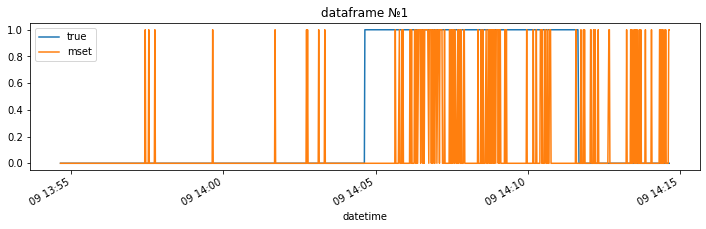

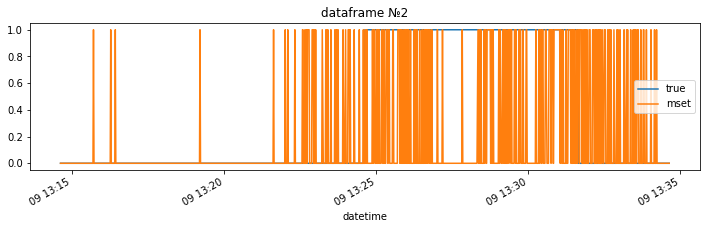

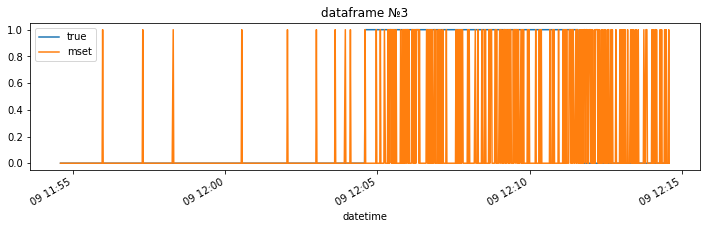

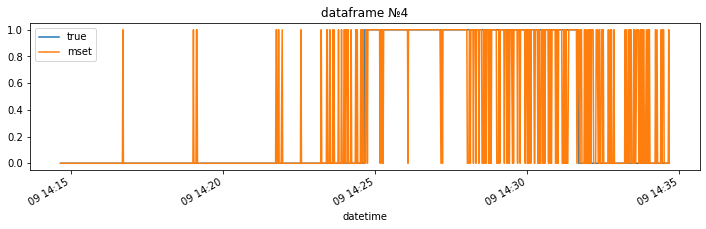

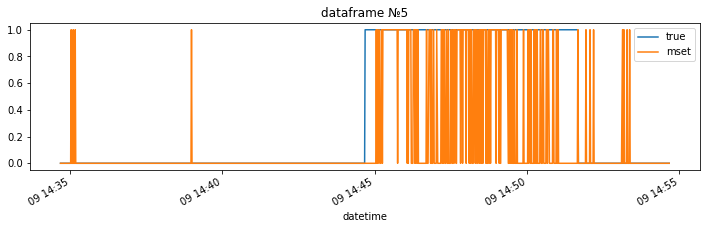

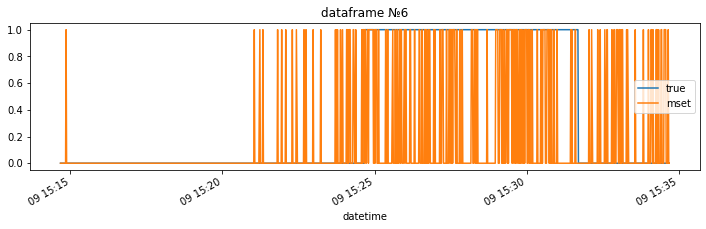

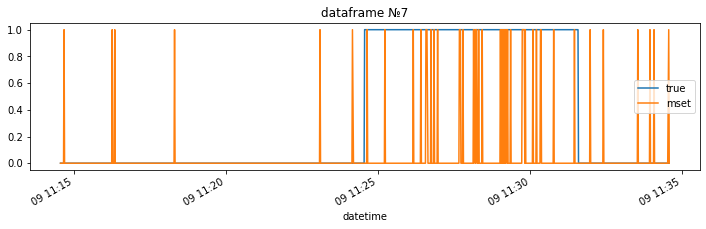

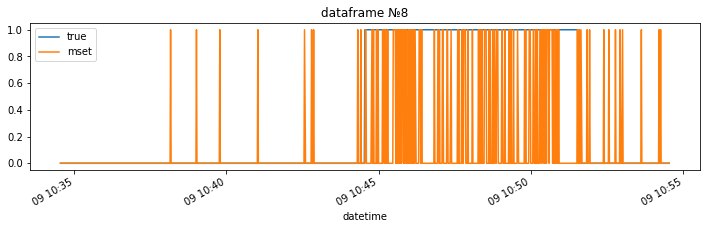

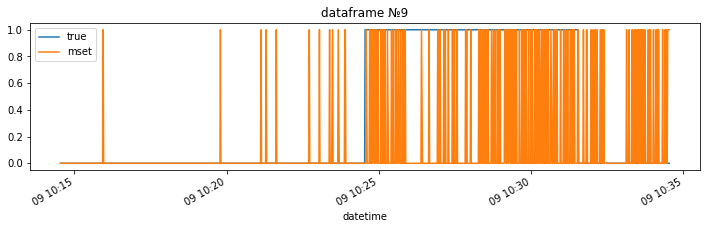

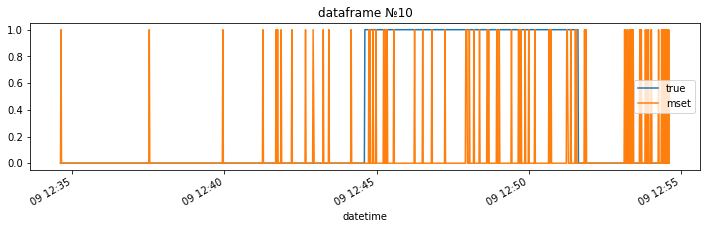

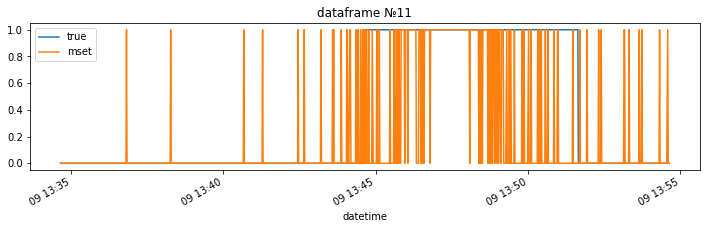

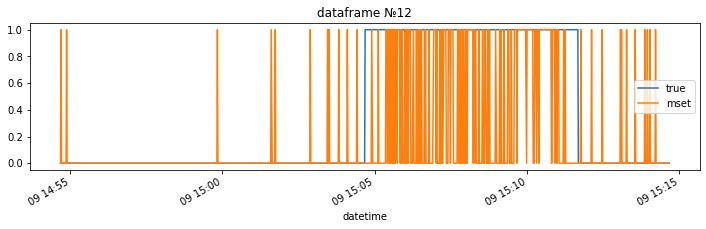

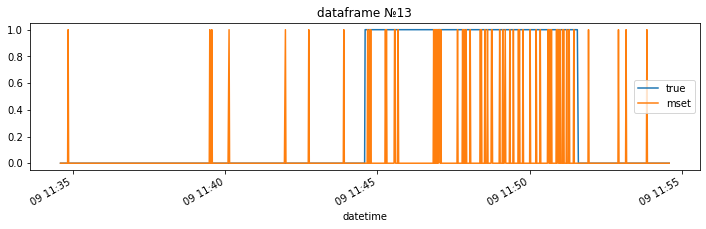

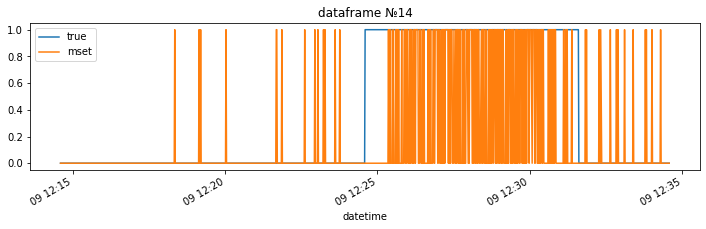

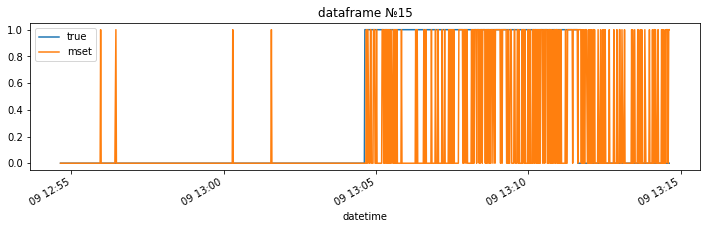

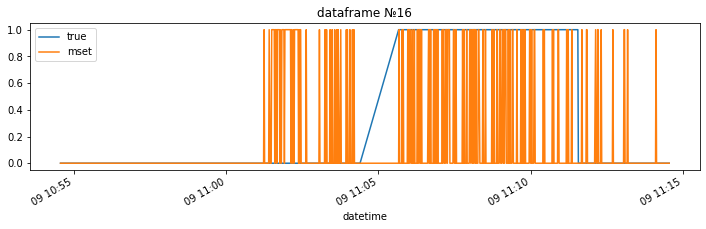

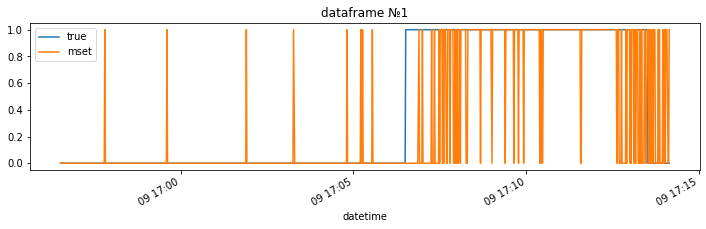

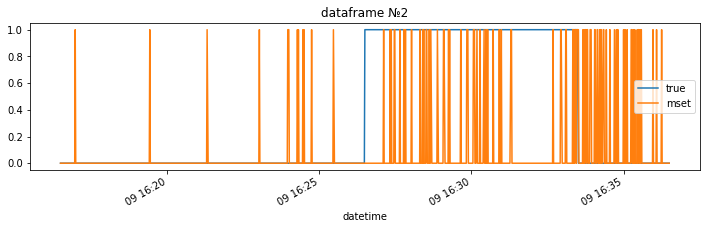

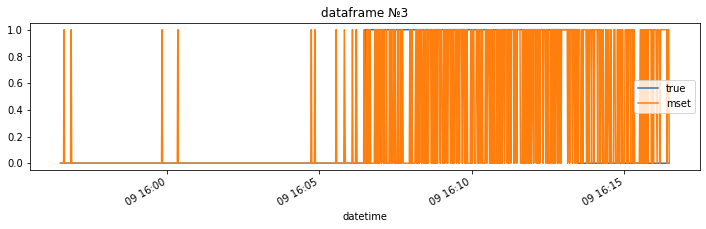

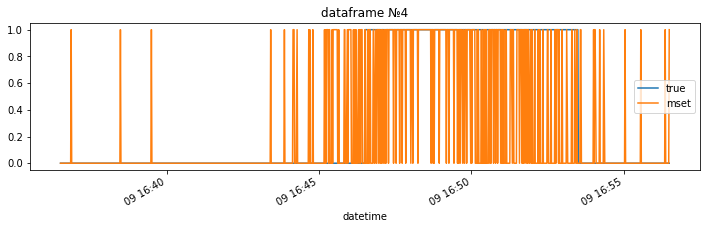

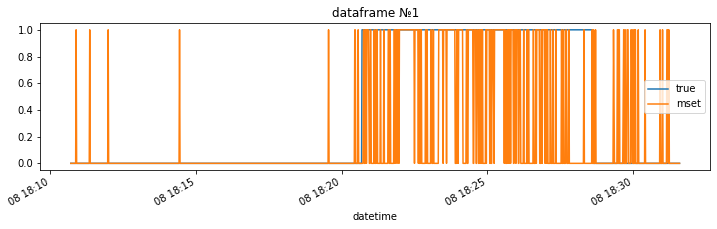

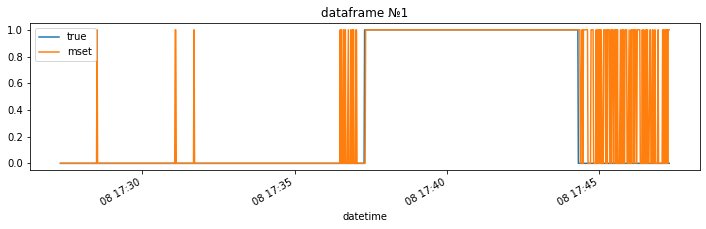

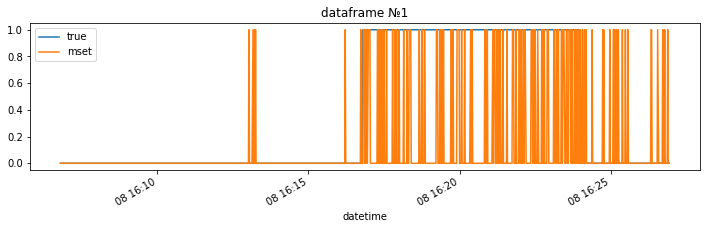

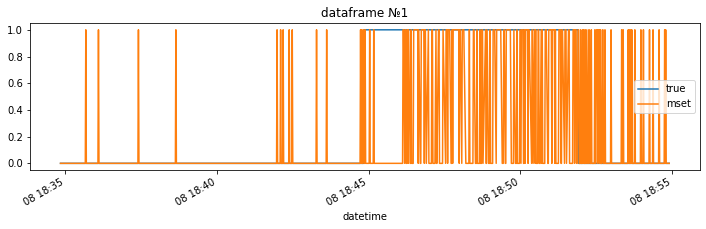

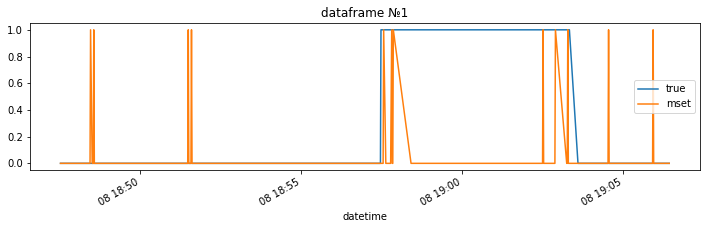

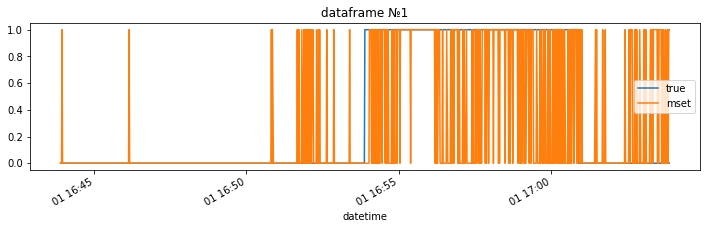

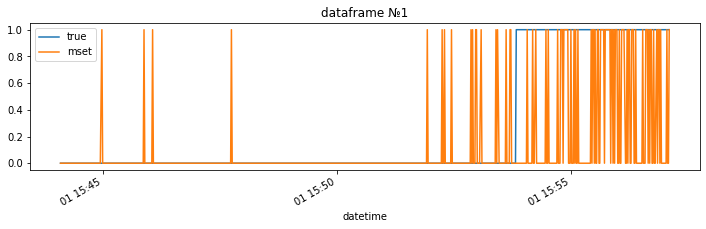

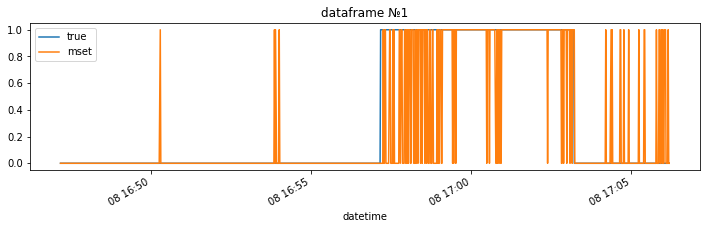

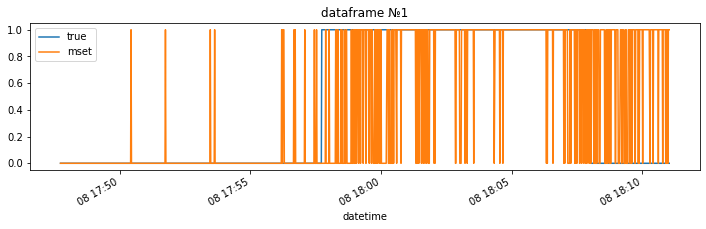

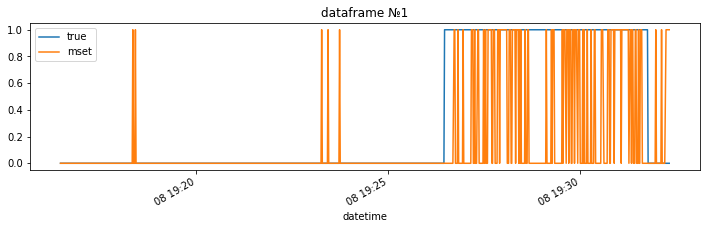

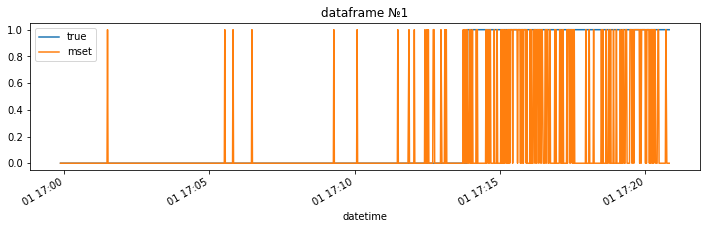

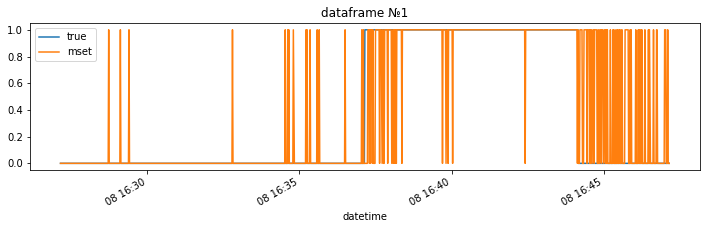

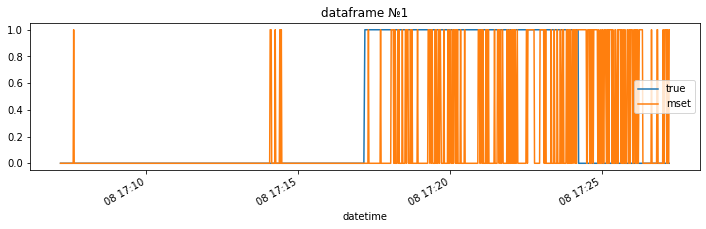

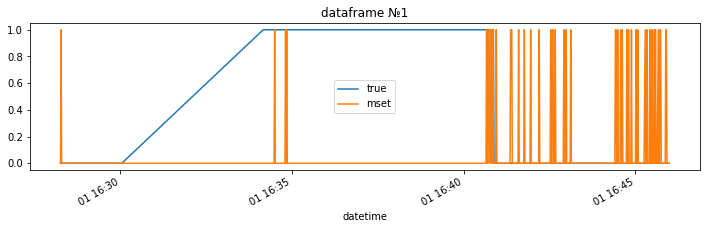

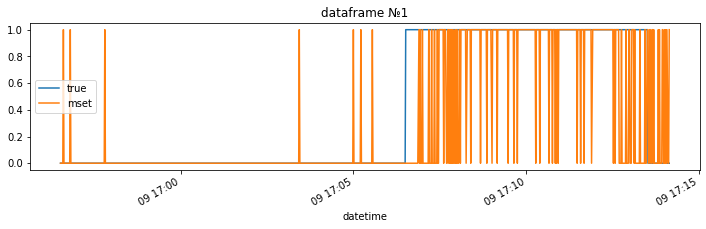

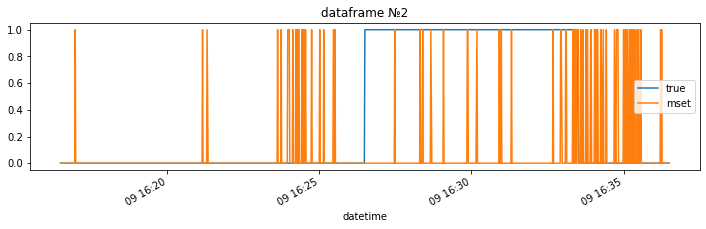

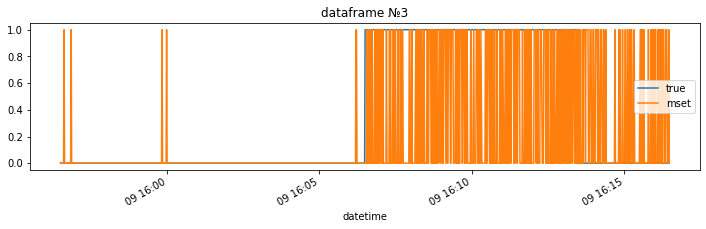

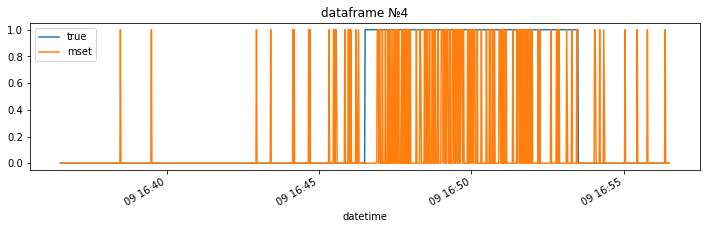

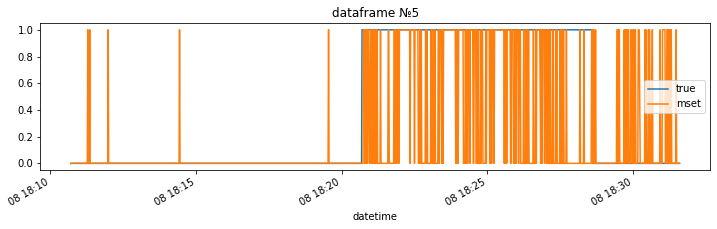

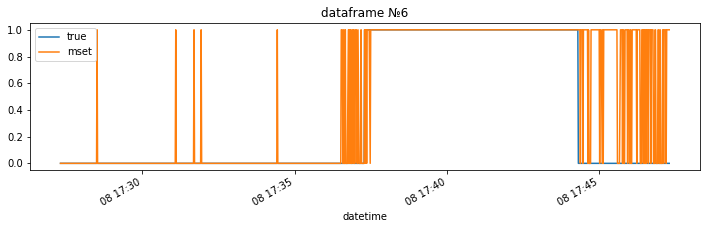

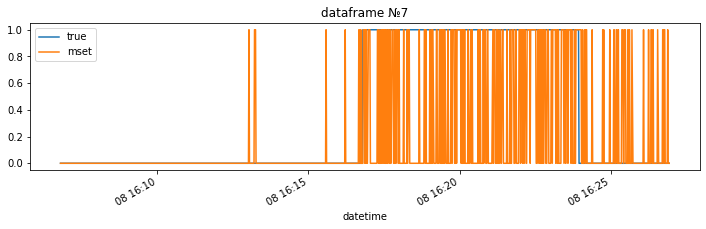

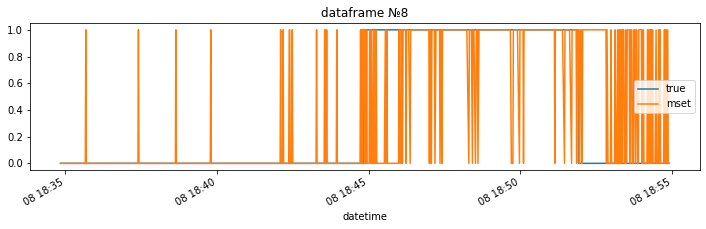

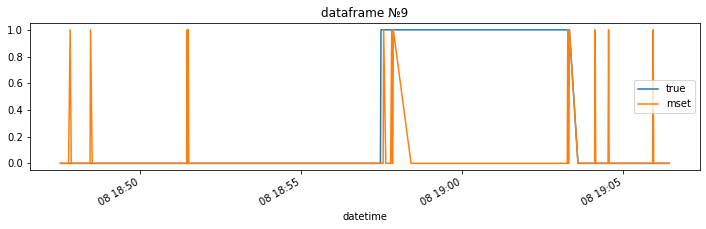

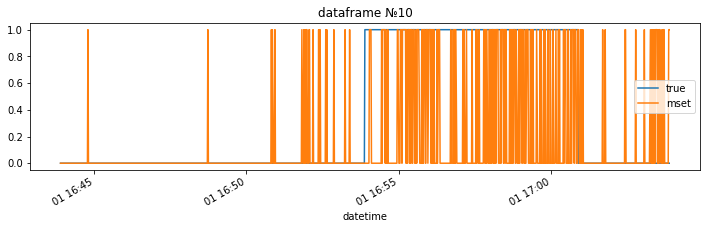

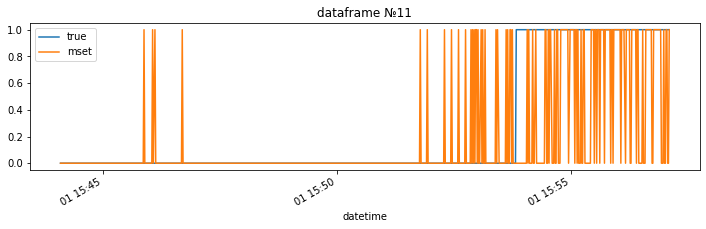

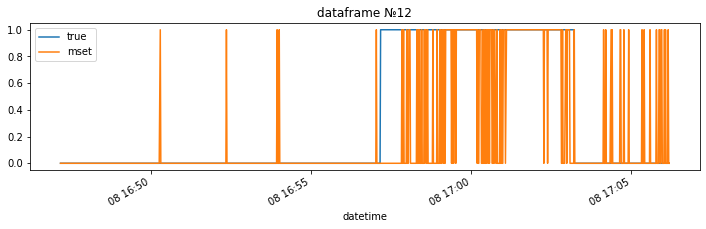

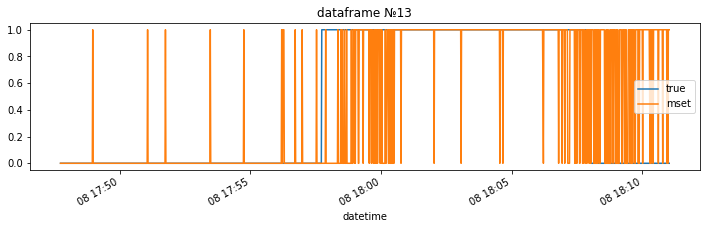

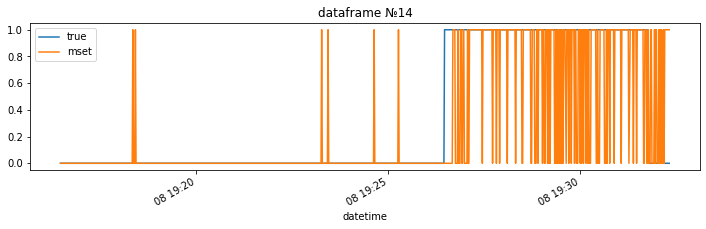

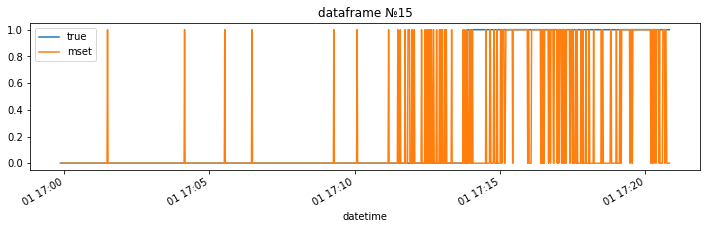

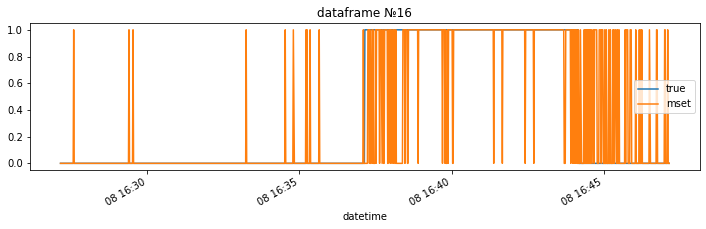

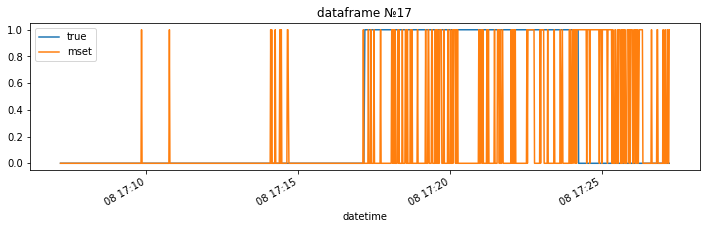

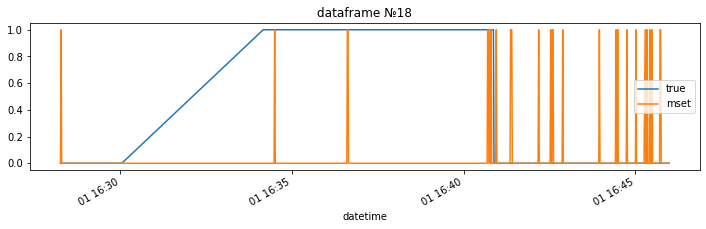

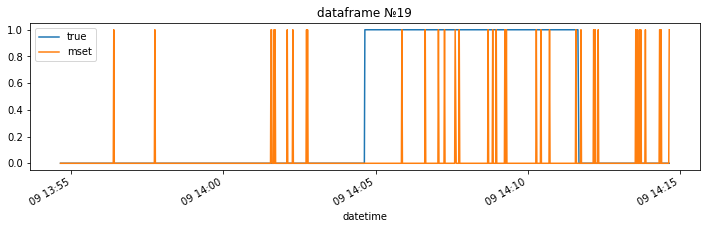

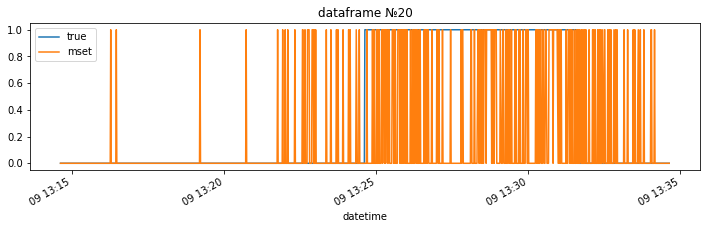

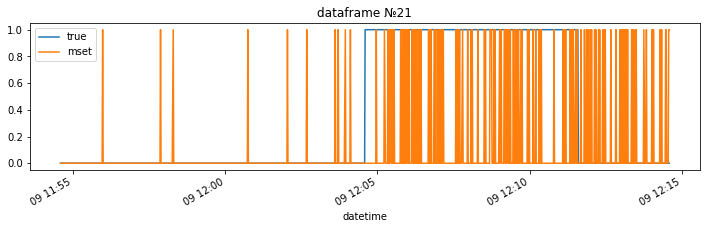

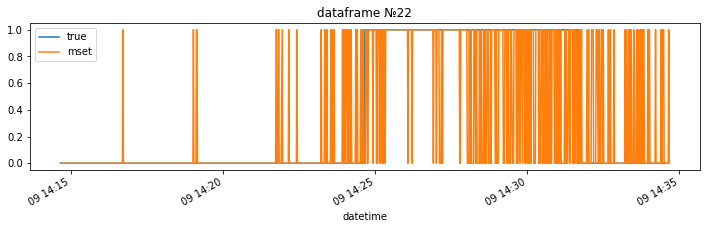

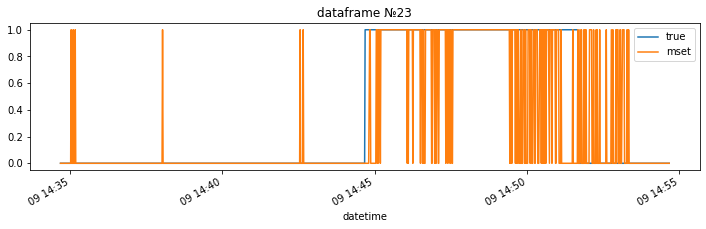

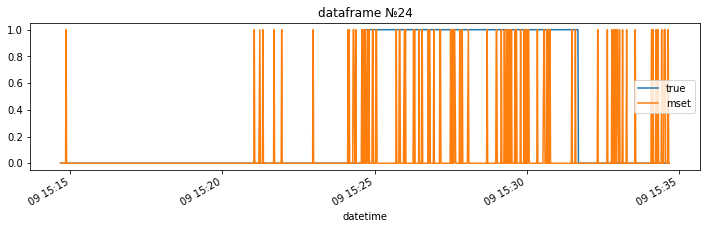

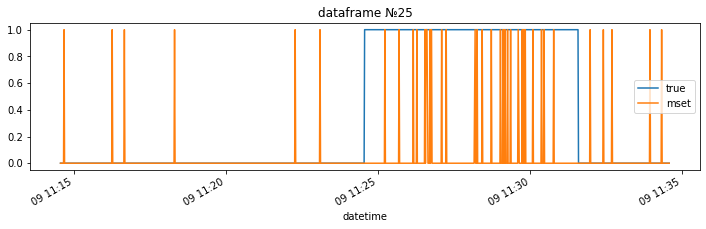

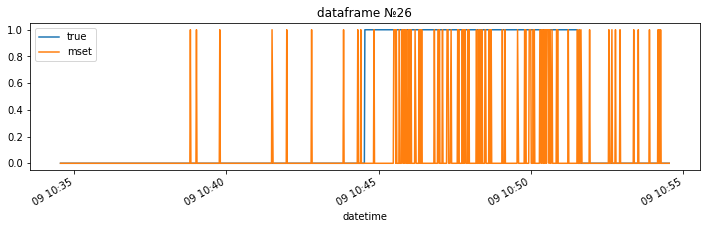

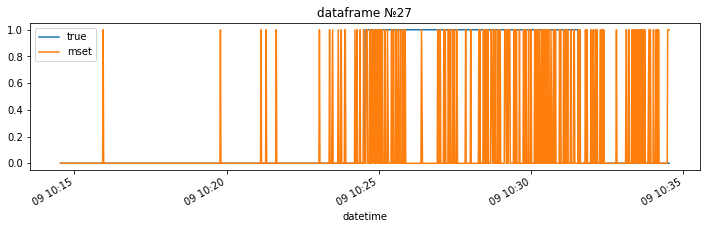

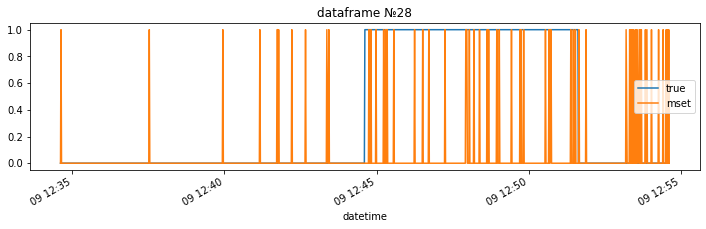

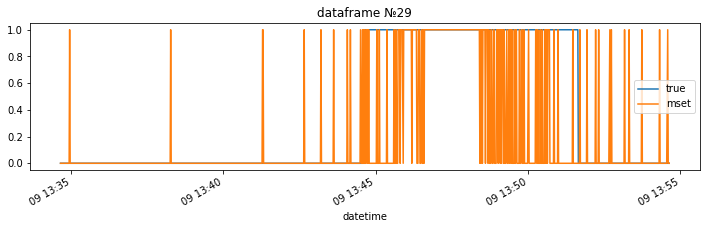

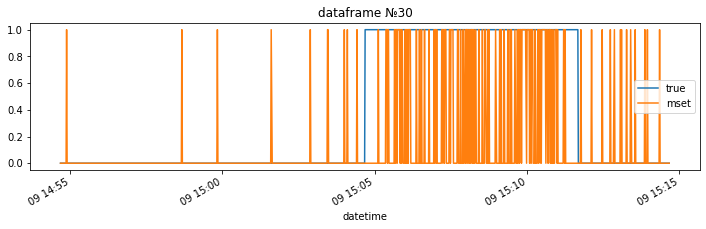

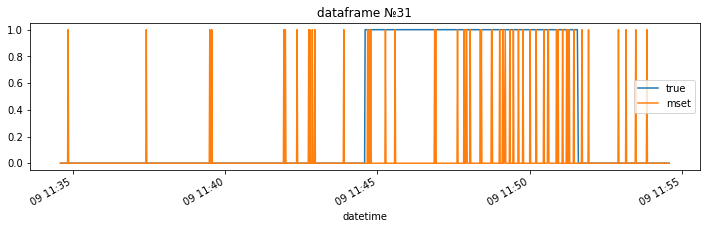

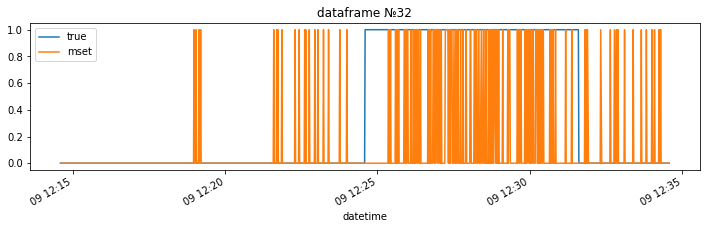

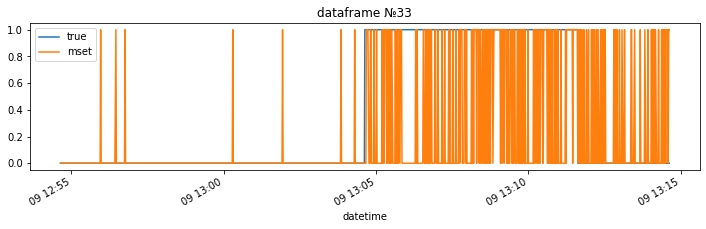

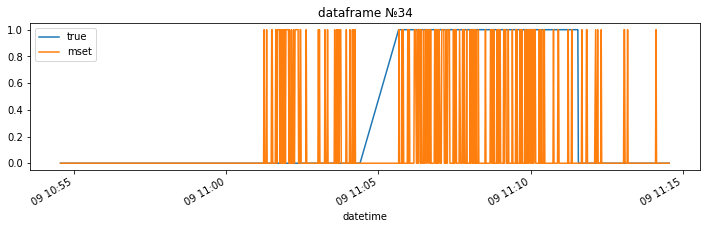

In [4]:
from utils.data import load_df

anomaly_types = ("valve1", "valve2", "other", "all", )
anomaly_groups = dict()

for anomaly_type in anomaly_types:
    list_of_df, _ = load_df("./data/", anomaly_type)
    if anomaly_type == "other":
        for i, df in enumerate(list_of_df):
            anomaly_groups[f"{anomaly_type}{i}"] = [df, ]
    else:
        anomaly_groups[f"{anomaly_type}"] = list_of_df

predictor = IForest_Predictor()
p = Pipeline()

metrics = dict()

for anomaly_type, list_of_df in anomaly_groups.items():
    metric = p.run(list_of_df, predictor, anomaly_description=anomaly_type)
    metrics[anomaly_type] = metric

In [5]:
from utils.data import show_score_table   
show_score_table(metrics)

metric | valve1 | valve2 | other0 | other1 | other2 | other3 | other4 | other5 | other6 | other7 | other8 | other9 | other10 | other11 | other12 | other13 | all
--- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | ---
F1 |0.45 | 0.6 | 0.61 | 0.89 | 0.38 | 0.52 | 0.04 | 0.65 | 0.5 | 0.83 | 0.75 | 0.55 | 0.5 | 0.87 | 0.36 | 0.05 | 0.52
FAR |0.06 | 0.09 | 0.04 | 0.13 | 0.04 | 0.07 | 0.01 | 0.09 | 0.03 | 0.03 | 0.19 | 0.02 | 0.03 | 0.11 | 0.13 | 0.09 | 0.07
MAR |0.68 | 0.5 | 0.53 | 0.0 | 0.74 | 0.59 | 0.98 | 0.43 | 0.64 | 0.24 | 0.25 | 0.61 | 0.65 | 0.07 | 0.73 | 0.97 | 0.61